# Introduction

This notebook presents sentiment analysis on [Kindle Book Reviews](http://jmcauley.ucsd.edu/data/amazon/) dataset.

**Dataset**

* [Amazon Review Data](http://jmcauley.ucsd.edu/data/amazon/) - download Kindle Store [5-core](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Kindle_Store_5.json.gz) file and extract

**Contents**

* [Load Data](#Load-Data) - load and preprocess
* [Preprocess Data](#Preprocess-Data) - cleanup and reduce noise
* [PyTorch Model](#PyTorch-Model) - build and train model

# Imports

In [1]:
import re
import time
import json
import collections
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Pick GPU if available

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Data

Download the dataset from [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Kindle_Store_5.json.gz) and extract. Point path below to extracted .json file.

In [4]:
dataset_location = '/home/marcin/Datasets/kindle-reviews/reviews_Kindle_Store_5.json'

In this section, we will read the data while performing following transforms:
* load the data
  * convert text to lower case
  * remove punctuation, digits etc.
  * split into words
* have a look at raw data

Each line in data file is a separate JSON entry

In [5]:
with open(dataset_location, 'r') as f:
    line_raw = f.readline()
line_raw

'{"reviewerID": "A1F6404F1VG29J", "asin": "B000F83SZQ", "reviewerName": "Avidreader", "helpful": [0, 0], "reviewText": "I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don\'t think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.", "overall": 5.0, "summary": "Nice vintage story", "unixReviewTime": 1399248000, "reviewTime": "05 5, 2014"}\n'

Lets print sample data item

In [6]:
line_json = json.loads(line_raw)
sample_score = line_json['overall']
sample_summary = line_json['summary']
sample_review = line_json['reviewText']
print('score:', sample_score)
print('summary:', sample_summary)
print('review:')
print(sample_review)

score: 5.0
summary: Nice vintage story
review:
I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.


Setup a function to help with transforms

In [7]:
regex = re.compile('[^a-zA-Z ]+')

def cleanup(text):
    res = regex.sub(' ', text)
    res = res.lower()
    return res.split()

print(cleanup(sample_review))

['i', 'enjoy', 'vintage', 'books', 'and', 'movies', 'so', 'i', 'enjoyed', 'reading', 'this', 'book', 'the', 'plot', 'was', 'unusual', 'don', 't', 'think', 'killing', 'someone', 'in', 'self', 'defense', 'but', 'leaving', 'the', 'scene', 'and', 'the', 'body', 'without', 'notifying', 'the', 'police', 'or', 'hitting', 'someone', 'in', 'the', 'jaw', 'to', 'knock', 'them', 'out', 'would', 'wash', 'today', 'still', 'it', 'was', 'a', 'good', 'read', 'for', 'me']


Lets load the whole dataset

In [8]:
reviews = []
summaries = []
scores = []
num_skipped = 0
print('|' + ' '*48 + '|')
with open(dataset_location, 'r') as f:
    for i, l in enumerate(f):
        jl = json.loads(l)
        
        review_text = cleanup(jl['reviewText'])
        summary_text = cleanup(jl['summary'])

        if len(review_text) == 0:
            num_skipped += 1
            continue
            
        reviews.append(review_text)
        summaries.append(summary_text)
        scores.append(int(jl['overall']))
        if i % 20000 == 0:
            print('.', end='')

print()
print('Num skipped:', num_skipped)

|                                                |
..................................................
Num skipped: 25


Dataset is loaded and cleaned, it should contain only lowercase letters and reviews should be split into words

**Look at the Data**

And lets have a look at few samples

In [9]:
def print_sample(idx):
    print('score:', scores[idx])
    print('summary:', summaries[idx])
    print('review:')
    print(reviews[idx])

In [10]:
for i in range(3):
    print_sample(i)
    print()

score: 5
summary: ['nice', 'vintage', 'story']
review:
['i', 'enjoy', 'vintage', 'books', 'and', 'movies', 'so', 'i', 'enjoyed', 'reading', 'this', 'book', 'the', 'plot', 'was', 'unusual', 'don', 't', 'think', 'killing', 'someone', 'in', 'self', 'defense', 'but', 'leaving', 'the', 'scene', 'and', 'the', 'body', 'without', 'notifying', 'the', 'police', 'or', 'hitting', 'someone', 'in', 'the', 'jaw', 'to', 'knock', 'them', 'out', 'would', 'wash', 'today', 'still', 'it', 'was', 'a', 'good', 'read', 'for', 'me']

score: 4
summary: ['different']
review:
['this', 'book', 'is', 'a', 'reissue', 'of', 'an', 'old', 'one', 'the', 'author', 'was', 'born', 'in', 'it', 's', 'of', 'the', 'era', 'of', 'say', 'nero', 'wolfe', 'the', 'introduction', 'was', 'quite', 'interesting', 'explaining', 'who', 'the', 'author', 'was', 'and', 'why', 'he', 's', 'been', 'forgotten', 'i', 'd', 'never', 'heard', 'of', 'him', 'the', 'language', 'is', 'a', 'little', 'dated', 'at', 'times', 'like', 'calling', 'a', 'gun', 

We will count all the different words

In [11]:
def count_words(list_of_examples):
    if isinstance(list_of_examples[0], str):
        split = True  # got list of strings, need to split words
    if isinstance(list_of_examples[0], list):
        split = False  # list of lists, already split by words
    
    words_counter = collections.Counter()
    for example in list_of_examples:
        if split:
            words_counter.update(example.split())
        else:
            words_counter.update(example)
            
    total_words = sum(list(words_counter.values()))
    unique_words = len(words_counter)
    
    return total_words, unique_words, words_counter

In [12]:
total_words, unique_words, words_counter = count_words(reviews)
print('Total words: ', total_words)
print('Unique words: ', unique_words)

Total words:  111201964
Unique words:  270677


We have over 110M words in total and 270k unique words

Lets have a look at word count distributions

In [13]:
def plot_counts(words_counter, title):
    sorted_all = np.array(sorted(list(words_counter.values()), reverse=True))
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[16,6])
    ax1.plot(sorted_all); ax1.set_title(title + ' Counts (linear scale)')
    ax2.plot(sorted_all); ax2.set_title(title + ' Counts (log scale)')
    ax2.set_yscale('log')

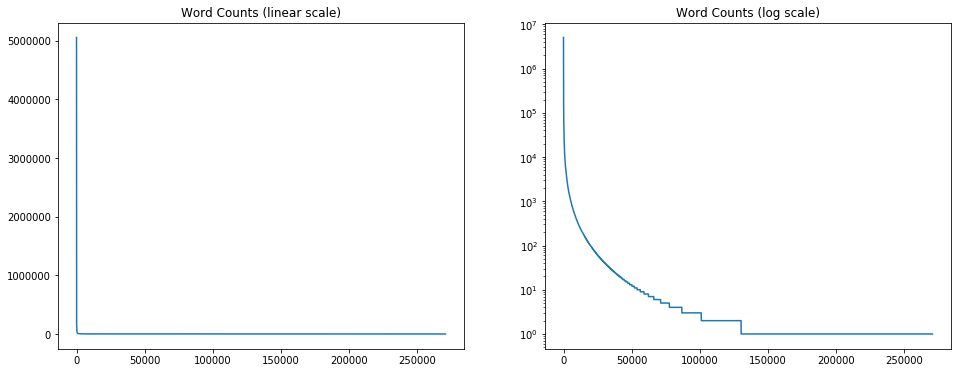

In [14]:
plot_counts(words_counter, title='Word')

This is extremely sharp distribution. Some words appear over 5 million times, while over 100k words appear only once.

Lets display some of the words and their number of occurrences in whole dataset

In [15]:
print('WORD    : COUNT')
for w in list(words_counter)[:10]:
    print(f'{w:8}: {words_counter[w]}')

WORD    : COUNT
i       : 3117051
enjoy   : 72405
vintage : 394
books   : 245937
and     : 3583503
movies  : 3701
so      : 493257
enjoyed : 146518
reading : 225740
this    : 1738403


# Preprocess Data

In this section we will perform following tasks:
* remove stopwords - remove words like 'the', 'a', 'an' and so on
* reduce vocabulary - remove very rare words that appear only few times
* tokenize dataset - convert words to ints

**Common Words**

Check most common words

In [16]:
display(words_counter.most_common()[:10])

[('the', 5056842),
 ('and', 3583503),
 ('to', 3120917),
 ('i', 3117051),
 ('a', 2999778),
 ('of', 2141725),
 ('is', 1780140),
 ('it', 1740139),
 ('this', 1738403),
 ('in', 1511066)]

Words like 'the', 'and', 'to' etc. don't contribute much to text meaning. They are called _stopwords_. Below is the list of stopwords in English language taken from [NLTK](https://www.nltk.org/) library. This set was created with:

```python
import nltk
nltk.download('stopwords')
en_stopwords = nltk.corpus.stopwords.words('english')
stopwords = {sw for sw in en_stopwords}
print(stopwords)
```

I'm just copy-pasting it here not to introduce otherwise unnecessary `nltk` dependency.

In [17]:
stopwords = {'down', 'then', 'of', 'but', 'only', 'yours', 'himself', 'again',
             'very', 'or', 'once', 'until', 'have', "doesn't", 'what', 'during',
             "that'll", 'some', 'was', 'be', 'he', "should've", 'between',
             "shouldn't", 'further', 'no', 'yourself', 'm', 've', "you'll",
             'ain', 't', 'our', 'his', 'o', 'wouldn', 'below', 'any', 'under',
             'you', 'isn', 'theirs', 'why', 'that', 'mightn', 'ourselves', 'on',
             'haven', 'while', 'to', 'than', 'your', 'she', 'is', 'just',
             "mightn't", 'with', "you've", 'mustn', 'needn', 'same', 'me',
             'such', 'myself', 'there', 'own', 'this', 're', 'ma', 'from',
             'did', 'couldn', 'hasn', 'for', 'won', "won't", "mustn't", 'her',
             'can', 'doesn', "wouldn't", 'when', "you're", 'who', 'which', 'll',
             'itself', 'against', 'out', 'up', "it's", 'a', 'here', 'being',
             'they', 'as', 'didn', 'weren', 'aren', 'herself', 'the', 'if',
             "didn't", 'should', 'doing', 'other', 'has', 'so', "you'd",
             'above', 'do', 'before', 'at', 'had', 'each', "aren't", 'their',
             'now', 'an', 'through', 'how', 'those', 'nor', "hasn't", 'over',
             'by', 'into', 'themselves', 'most', 'shan', 'been', "she's",
             "haven't", "isn't", "wasn't", 'where', 'about', 'in', "hadn't",
             'because', 'too', 'whom', 'ours', 'him', 'yourselves', 'after',
             'and', 'were', 'both', 'will', 'it', 'my', 'few', 'having', 'them',
             'hadn', 'shouldn', 'does', 's', "couldn't", 'y', 'all', 'don',
             'off', 'more', 'am', 'd', 'hers', 'its', 'are', "shan't",
             "weren't", 'we', "needn't", 'i', 'these', "don't", 'wasn', 'not'}

Remove stopwords

In [18]:
def remove_stopwords(list_of_examples, stopwords, print_progress=False):
    result_no_stop = []
    if print_progress: print('|' + ' '*48 + '|')
    for i, list_of_words in enumerate(list_of_examples):
        result_no_stop.append( [w for w in list_of_words if w not in stopwords])
        if print_progress and i % (len(list_of_examples)//49) == 0:
            print('.', end='')
    return result_no_stop

In [19]:
reviews_no_stop = remove_stopwords(reviews, stopwords, print_progress=True)

|                                                |
..................................................

Lets see if we introduced any empty reviews with this operation?

In [20]:
indices_empty = [i for i, rev in enumerate(reviews_no_stop) if len(rev) == 0]
print('Indices of empty reviews:', indices_empty)

Indices of empty reviews: [335748, 457502, 581157, 717096, 737793, 875074, 941022]


Not too many, lets just remove them

In [21]:
if len(reviews) == len(reviews_no_stop):  # don't exec this cell twice by accidend
    for idx in reversed(indices_empty):   # must go backwards
        del reviews_no_stop[idx]
        del scores[idx]

Make sure it worked

In [22]:
indices_empty = [i for i, rev in enumerate(reviews_no_stop) if len(rev) == 0]
print('Indices of empty reviews:', indices_empty)

Indices of empty reviews: []


Print sample review

In [23]:
print(reviews_no_stop[0])

['enjoy', 'vintage', 'books', 'movies', 'enjoyed', 'reading', 'book', 'plot', 'unusual', 'think', 'killing', 'someone', 'self', 'defense', 'leaving', 'scene', 'body', 'without', 'notifying', 'police', 'hitting', 'someone', 'jaw', 'knock', 'would', 'wash', 'today', 'still', 'good', 'read']


And count words

In [24]:
total_words, unique_words, words_counter = count_words(reviews_no_stop)
print('Total words: ', total_words)
print('Unique words: ', unique_words)

Total words:  53101559
Unique words:  270524


We are down to 53M total from 110M by removing meaningless words.

**Reduce Vocabulary**

Lets look at some of of the uncommon words. Most of them are misspelled and provide no transferable information

In [25]:
display(words_counter.most_common()[-10:])

[('somethingthatisdoneveryquickly', 1),
 ('ofsexualintercoursethatisdonein', 1),
 ('averyshort', 1),
 ('amountoftimeanticipation', 1),
 ('afeelingofexcitementaboutsomethingthatisgoingto', 1),
 ('ofpreparingforsomething', 1),
 ('fieldingit', 1),
 ('chenell', 1),
 ('waitign', 1),
 ('uunderstand', 1)]

In [26]:
def reduce_vocabulary(list_of_examples, min_occurances, unk_tok='<UNK>', print_=False):
    words_ctr = collections.Counter()
    for example in list_of_examples:
        words_ctr.update(example)
    
    result_reduced = []
    if print_: print('|' + ' '*48 + '|')
    for i, list_of_words in enumerate(list_of_examples):
        tmp = [w if words_ctr[w] >= min_occurances else unk_tok for w in list_of_words]
        result_reduced.append( tmp )
        if print_ and i % (len(list_of_examples)//49) == 0:
            print('.', end='')
    return result_reduced

In [27]:
reviews_reduced = reduce_vocabulary(reviews_no_stop, min_occurances=50, print_=True)

|                                                |
..................................................

Show sample after reduction

In [28]:
print(reviews_reduced[1])

['book', '<UNK>', 'old', 'one', 'author', 'born', 'era', 'say', 'nero', 'wolfe', 'introduction', 'quite', 'interesting', 'explaining', 'author', 'forgotten', 'never', 'heard', 'language', 'little', 'dated', 'times', 'like', 'calling', 'gun', '<UNK>', 'also', 'made', 'good', 'use', 'fire', 'dictionary', 'look', 'words', 'like', '<UNK>', '<UNK>', 'still', 'well', 'worth', 'look', 'see']


In [29]:
total_words, unique_words, words_counter = count_words(reviews_reduced)
print('Total words: ', total_words)
print('Unique words: ', unique_words)

Total words:  53101559
Unique words:  27319


**Create dictionaries**

In [31]:
i2w = {i : w for i, (w, c) in enumerate(words_counter.most_common(), 1)}
w2i = {w : i for i, w in i2w.items()}
i2w[0] = '<PAD>'                       # use zero index for padding
w2i[i2w[0]] = 0
print('Number of words after filter:', len(i2w))

Number of words after filter: 27320


Confirm dictionaries are correct

In [32]:
for i in range(10):
    word = i2w[i]
    print(i, ':', word, ':', w2i[word])

0 : <PAD> : 0
1 : book : 1
2 : <UNK> : 2
3 : story : 3
4 : read : 4
5 : one : 5
6 : love : 6
7 : like : 7
8 : really : 8
9 : good : 9


Print subset of vocabulary, alphabetically sorted

In [33]:
print(sorted(list(i2w.values()))[:100])

['<PAD>', '<UNK>', 'aa', 'aaa', 'aacute', 'aaliyah', 'aaron', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandons', 'abbey', 'abbi', 'abbie', 'abbot', 'abbott', 'abbreviated', 'abbreviations', 'abby', 'abc', 'abcs', 'abd', 'abduct', 'abducted', 'abducting', 'abduction', 'abductions', 'abductor', 'abdulla', 'abe', 'abel', 'aber', 'abercrombie', 'abhor', 'abhorrent', 'abi', 'abide', 'abiding', 'abigail', 'abilities', 'ability', 'abit', 'abject', 'ablaze', 'able', 'ably', 'abnormal', 'abo', 'aboard', 'abomination', 'aboriginal', 'abortion', 'abound', 'abounds', 'abraham', 'abram', 'abrams', 'abrasive', 'abridged', 'abroad', 'abrupt', 'abruptly', 'abruptness', 'abs', 'absence', 'absent', 'absentee', 'absinthe', 'abso', 'absolute', 'absolutely', 'absolution', 'absolutley', 'absolutly', 'absorb', 'absorbed', 'absorbing', 'absorption', 'abstinence', 'abstract', 'absurd', 'absurdity', 'absurdly', 'abt', 'abundance', 'abundant', 'abundantly', 'abuse', 'abused', 'abuser

**Tokenize Dataset**

Convert words into integer tokens

In [34]:
def tokenize(list_of_examples, word2idx):
    result_tokenized = []
    for list_of_words in list_of_examples:
        result_tokenized.append( [word2idx[w] for w in list_of_words] )
    return result_tokenized

In [35]:
reviews_tok = tokenize(reviews_reduced, w2i)

Show example

In [36]:
print(reviews_tok[2])

[1049, 82, 4, 154, 276, 7188, 233, 16, 4, 3, 12358, 2, 4, 86, 8165, 7, 167, 2, 594, 319, 893, 614, 7578, 93, 4106, 2, 4844, 3, 134, 4852, 663]


**Trimming and Padding**

Lets have a look at review lengths next

In [37]:
lengths = np.array([len(r) for r in reviews_tok])
lenghts_counter = collections.Counter(lengths)

In [43]:
print('Shortest review:', lengths.min())
print('Longest review: ', lengths.max())

Shortest review: 1
Longest review:  2040


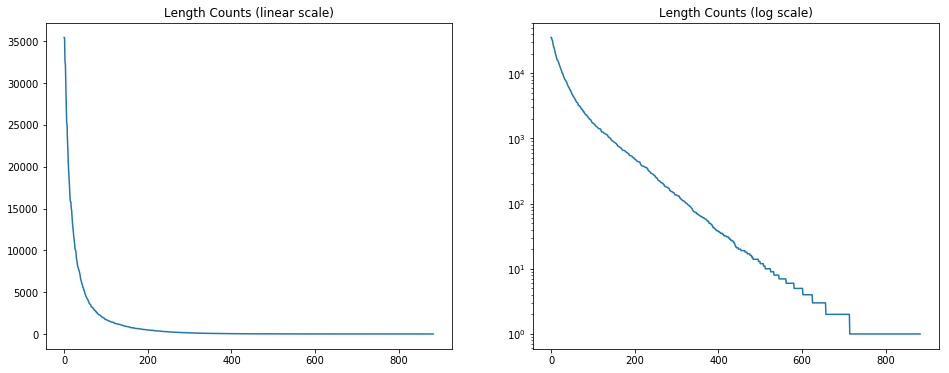

In [44]:
plot_counts(lenghts_counter, title='Length')

We can most of the reviews are roughly below 200 words long

Lets see how many reviews are over 200 words long

In [45]:
num_over_200 = (lengths > 200).sum()
precentage_over_200 = 100*num_over_200 / len(lengths)
print('Num over 200:        ', num_over_200)
print('Precentage over 200: ', round(precentage_over_200, 2))

Num over 200:         39019
Precentage over 200:  3.97


To feed reviews into neural network in mini-batches all reviews have to have same length.

We will:
* trim all reviews to 200 words
* pad all shorter reviews with &lt;NOP&gt;

In [46]:
def trim_and_pad(list_of_examples, target_len, dtype):
    result_np = np.zeros(shape=(len(reviews_tok), target_len), dtype=dtype)
    
    for i in range(len(list_of_examples)):
        example_trimmed = list_of_examples[i][:target_len]      # trim
        start = target_len - len(example_trimmed)
        result_np[i, start:target_len] = example_trimmed
        
    return result_np

Vocabulary size is a bit over 27k words, so it will fit in the int16 type

In [53]:
target_type = np.int16
assert len(i2w) < np.iinfo(target_type).max
reviews_np = trim_and_pad(reviews_tok, target_len=200, dtype=target_type)

In [54]:
print(reviews_np)

[[   0    0    0 ...   57    9    4]
 [   0    0    0 ...  166  119   27]
 [   0    0    0 ...  134 4852  663]
 ...
 [   0    0    0 ...  112   70   32]
 [   0    0    0 ...    6   43   70]
 [   0    0    0 ... 3340  338   70]]


In [55]:
print(reviews_np[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   98 9303   17 1998   34   18    1   88 1380   38 1441  169
  315 4370  720  333  475  134    2  991 3979  169 4371 3404   13 8263
  674 

In [56]:
' '.join(i2w[c] for c in reviews_np[0] if c != 0)

'enjoy vintage books movies enjoyed reading book plot unusual think killing someone self defense leaving scene body without <UNK> police hitting someone jaw knock would wash today still good read'

**Convert Labels**

Lets just check class distribution before we do anything

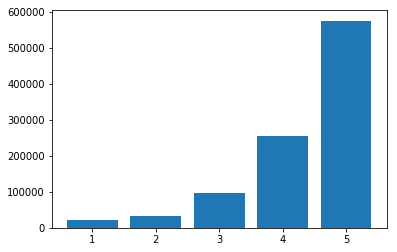

In [57]:
scores_counter = collections.Counter(scores)
plt.bar(scores_counter.keys(), scores_counter.values())
plt.plot();

Ok, this is not very well balanced dataset :S. There is not much we can do about it here, we deal with it later

In [58]:
s2s = {1:0, 2:0, 3:1, 4:2, 5:2 }        # convert scores to 3-way scale neg/mix/pos
scores_np = np.array([s2s[s] for s in scores])
assert len(reviews_np) == len(scores_np)

Sanity check

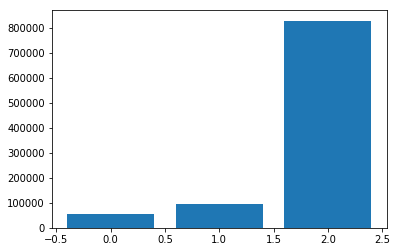

In [59]:
scores_counter = collections.Counter(scores_np)
plt.bar(scores_counter.keys(), scores_counter.values())
plt.plot();

**Save to file**

In [60]:
np.savez('data_lstm.npz',
        reviews_np=reviews_np,
        scores_np=scores_np)

# Checkpoint!

In [61]:
import re
import time
import json
import collections
import numpy as np
import matplotlib.pyplot as plt

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Pick GPU if available

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Load from file**

In [64]:
npzfile = np.load('data_lstm.npz')
reviews_np = npzfile['reviews_np'].astype(np.uint8)
scores_np = npzfile['scores_np']
del npzfile

KeyError: 'reviews_enc is not a file in the archive'

**Shuffle and Split**

Create index array and shuffle

In [38]:
indices = np.array(range(len(reviews_np)))
np.random.shuffle(indices)

Calculate split points and split

In [39]:
train_split_index = int(len(reviews_np) * .90)
valid_split_index = int(len(reviews_np) * .95)

train_i, valid_i, test_i = np.split(
    indices, [train_split_index, valid_split_index])

print('Nb train reviews:', len(train_i))
print('Nb valid reviews: ', len(valid_i))
print('Nb test reviews:  ', len(test_i))

Nb train reviews: 884357
Nb valid reviews:  49131
Nb test reviews:   49131


Split the dataset into three parts

In [40]:
train_x, train_y = reviews_np[train_i], scores_np[train_i]
valid_x, valid_y = reviews_np[valid_i], scores_np[valid_i]
test_x, test_y = reviews_np[test_i], scores_np[test_i]

In [41]:
train_x = torch.tensor(train_x, device=device)
train_y = torch.tensor(train_y, device=device)
valid_x = torch.tensor(valid_x, device=device)
valid_y = torch.tensor(valid_y, device=device)

# Train Model

In [370]:
class SentimentNetwork(nn.Module):
    def __init__(self, nb_layers, n_vocab, n_embed, n_hid, n_out, dropout):
        super(SentimentNetwork, self).__init__()
        
        self.embed = nn.Embedding(num_embeddings=n_vocab, embedding_dim=n_embed)
        self.lstm = nn.LSTM(input_size=n_embed, hidden_size=n_hid, num_layers=nb_layers,
                           batch_first=True, dropout=dropout)
        self.drop = nn.Dropout(p=dropout)
        self.fc = nn.Linear(in_features=n_hid, out_features=n_out)
        
    def forward(self, x):
        x = self.embed(x)                   # shape [n_batch, n_seq, n_embed]
        x, _ = self.lstm(x)                 # shape [n_batch, n_seq, n_hid]
        x = x[:, -1, :]                     # shape [n_batch, n_hid]
        return self.fc(x)                   # shape [n_batch, n_out]
    
#     def init_hidden(self, n_batch):
#         x = torch.zeros(n_batch, 1, dtype=torch.int64, device=device)
#         x = self.embed(x)
#         _, self.hidden = self.lstm(x)

In [375]:
nb_layers = 2
n_vocab = len(i2w)
n_embed = 300
n_hid = 512
n_out = 3              # neg/mix/pos
n_batch = 256

In [376]:
model = SentimentNetwork(nb_layers, n_vocab, n_embed, n_hid, n_out, dropout=.5)
model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy(logits, labels): 
    predictions = torch.argmax(logits, dim=1)
    return (predictions == labels).float().mean()  # tensor!!

In [ ]:
def per_class_accuracy(y_true, y_pred, nb_classes):
    
    y_correct = y_true == y_hat
    result = torch.zeros(nb_classes)
    for c in range(nb_classes):
        curr_class =  y_true == c
        class_correct = y_true[curr_class] == y_hat[curr_class]
        class_acc = class_correct.sum(dtype=torch.float) / len(class_correct)
        result[c] = class_acc
        
    return result.cpu().numpy()

In [428]:
def evaluate(data_x, data_y):
    
    pred_y = torch.zeros_like(data_y) + 7  # model outputs
    
    model.eval()
    loss_sum, acc_sum = 0, 0
    with torch.no_grad():        
        for i in range(0, len(data_x), n_batch):

            # Pick mini-batch
            inputs = data_x[i:i+n_batch]
            targets = data_y[i:i+n_batch]

            # Forward pass
            outputs = model(inputs)                      # logits
            loss = criterion(outputs, targets)
            acc = accuracy(outputs, targets)

            pred_y[i:i+n_batch] = outputs.argmax(dim=1)  # logits
            
            # Record per-iteration loss
            loss_sum += loss.item() * len(inputs)
            acc_sum += acc.item() * len(inputs)
            
        nb_classes = outputs.shape[1]
        class_acc = per_class_accuracy(data_y, pred_y, nb_classes)

    loss_avg = loss_sum / len(data_x)
    acc_avg = acc_sum / len(data_x)
    
    return loss_avg, acc_avg, class_acc

In [377]:
trace = {'epoch': [], 'tloss': [], 'vloss': []}    # per epoch
trace2 = {'loss' : []}                             # per iteration

nb_epochs = 1

In [378]:
#def train(nb_epochs, trace, trace2):
if True:

    epoch = len(trace['epoch'])

    for _ in range(nb_epochs):

        time_start = time.time()

        #
        #   Train Model
        #
        model.train()
        tloss_sum = 0
        hidden = None                                  # reset LSTM hidden state
        for i in range(0, len(train_x), n_batch):

            # Pick mini-batch
            inputs = train_x[i:i+n_batch]    # [n_batch, n_seq], less for last batch
            targets = train_y[i:i+n_batch]   # [n_batch, n_seq], less for last batch
            
            # Optimize
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                acc = accuracy(outputs, targets)
                tloss_sum += loss.item() * len(inputs)
                tacc_sum  += acc.item() * len(inputs)
                
            
            if i % (100*n_batch) == 0:
                percent_complete = i * 100 / len(train_x)
                time_delta = time.time() - time_start
                print(f'Epoch: {epoch:3} ({percent_complete:.0f}%)     '
                      f'Loss: {loss:.4f}     Time: {time_delta:.2f}s')
                
                loss, acc, class_acc = evaluate(valid_x, valid_y)


#         tloss_avg = tloss_sum / train_size

#         #
#         #   Evaluate Model
#         #
#         model.eval()
#         vloss_sum = 0
#         hidden = None
#         with torch.no_grad():        
#             for i in range(0, valid_size, n_seq):

#                 # Pick mini-batch
#                 inputs = valid_x[:,i:i+n_seq]
#                 targets = valid_x[:,i+1:i+1+n_seq]
#                 if inputs.shape[1] != targets.shape[1]:
#                     inputs = inputs[:,:-1]

#                 # Optimize
#                 outputs, hidden = model(inputs, hidden)
#                 loss = criterion(outputs.view(-1, n_out), targets.flatten())

#                 # Record per-iteration loss
#                 vloss_sum += loss.item() * inputs.shape[1]

#         vloss_avg = vloss_sum / valid_size

        #
        #   Logging
        #

#         time_delta = time.time() - time_start

#         trace['epoch'].append(epoch)
#         trace['tloss'].append(tloss_avg)
#         trace['vloss'].append(vloss_avg)
        
#         #
#         #   Print loss
#         #
#         print(f'Epoch: {epoch:3}     '
#               f'T/V Loss: {tloss_avg:.4f} / {vloss_avg:.4f}     '
#               f'Time: {time_delta:.2f}s')

#         epoch += 1

Epoch:   0 (0%)     Loss: 1.1156     Time: 0.31s
Epoch:   0 (3%)     Loss: 0.3986     Time: 31.63s
Epoch:   0 (6%)     Loss: 0.3837     Time: 65.80s


KeyboardInterrupt: 

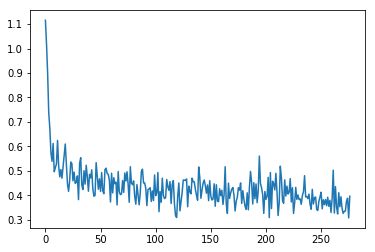

In [380]:
plt.plot(trace2['loss'])

In [ ]:
#         model.eval()
#         vloss_sum = 0
#         hidden = None
#         with torch.no_grad():        
#             for i in range(0, valid_size, n_seq):

#                 # Pick mini-batch
#                 inputs = valid_x[:,i:i+n_seq]
#                 targets = valid_x[:,i+1:i+1+n_seq]
#                 if inputs.shape[1] != targets.shape[1]:
#                     inputs = inputs[:,:-1]

#                 # Optimize
#                 outputs, hidden = model(inputs, hidden)
#                 loss = criterion(outputs.view(-1, n_out), targets.flatten())

#                 # Record per-iteration loss
#                 vloss_sum += loss.item() * inputs.shape[1]

#         vloss_avg = vloss_sum / valid_size


In [429]:
loss, acc, class_acc = evaluate(valid_x, valid_y)
print(loss, acc, class_acc)

0.3813960278067694 0.8655024321370272 [0.3570695  0.20452604 0.9758224 ]


In [416]:
per_class_accuracy(valid_y, predictions, nb_classes=3)

array([0.3570695 , 0.20452604, 0.9758224 ], dtype=float32)

In [408]:
y_true = valid_y
y_hat = predictions
nb_classes = 3


In [409]:
result

tensor([0.3571, 0.2045, 0.9758])

In [391]:
sum(y_correct)

tensor(27, device='cuda:0', dtype=torch.uint8)

In [396]:
result

tensor([0., 2., 1.])

tensor(1043., device='cuda:0')

In [392]:
y_hat = predictions.cpu().numpy()
y_true = valid_y.cpu().numpy()
get_class_coverage(y_true, y_hat, 3)

array([0.3570695 , 0.20452605, 0.97582238])

In [242]:
def plot_class_coverage(y, y_hat, axis=None):
    #
    #   Per-class accuracy
    #
    assert y.ndim == 2 and y_hat.ndim == 2
    assert y.shape == y_hat.shape
    
    nb_classses = y.shape[-1]
    
    y_correct = np.argmax(y, axis=-1) == np.argmax(y_hat, axis=-1)
    classes_correct = []
    classes_all = []
    for i in range(nb_classses):
        is_y_class_i = y_correct * (np.argmax(y, axis=-1)==i)
        nb_correct_class_i = np.sum(is_y_class_i)
        classes_correct.append(nb_correct_class_i)
        classes_all.append(np.count_nonzero(np.argmax(y, axis=-1)==i))
    classes_correct = np.array(classes_correct)
    classes_all = np.array(classes_all)

    if axis is None:
        fig, axis = plt.subplots()
    
    axis.bar(range(10), classes_all, label='All Member')
    axis.bar(range(10), classes_correct, label='Correctly Predicted')
    axis.legend(loc=3)

In [243]:
plot_class_coverage(y_true, y_hat)

AssertionError: 

In [222]:
loss_avg, acc_avg = evaluate(train_x, train_y)
print(loss_avg, acc_avg)

0.2872463878780543 0.89192034439275


In [229]:
outputs.argmax(dim=1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2,
        2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2,
        0, 2, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
        2, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2,

In [209]:
loss.item()

0.2804724872112274

In [206]:
model(valid_x)

RuntimeError: CUDA out of memory. Tried to allocate 10.98 GiB (GPU 0; 11.93 GiB total capacity; 6.76 GiB already allocated; 3.80 GiB free; 294.47 MiB cached)

In [205]:
49131*200*8

78609600

In [185]:
targets.shape

torch.Size([512])